<a href="https://colab.research.google.com/github/Dedeep007/PROVIS/blob/main/PROVIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class PromptImageData(Dataset):
    def __init__(self, csv_file, root_dir='', transform=None, limit=None):
        self.data = pd.read_csv(csv_file)
        if limit:
            self.data = self.data.iloc[:limit].reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        prompt = self.data.iloc[idx]['prompt']
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['image_file'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            'prompt': prompt,   # Raw text
            'image': image      # Transformed image
        }


In [4]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset (limit to 5000 for fast experimentation)
full_dataset = PromptImageData(
    csv_file=r"D:\PROVIS\custom_prompts_df.csv",
    root_dir=r"D:\PROVIS",
    transform=transform,
    limit=10000
)

# Split into training and validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
generator = torch.Generator().manual_seed(SEED)

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

# Print example batch info
def print_batch(loader, name=""):
    print(f"\n{name} Batch Example:")
    batch = next(iter(loader))
    print("Image tensor shape:", batch['image'].shape)  # [B, 3, 320, 320]
    print("Prompt (text) example:", batch['prompt'][0])  # Just show 1st text prompt

print_batch(train_loader, "Train")
print_batch(val_loader, "Validation")

print(f"\nTotal training examples: {len(train_dataset)}")
print(f"Total validation examples: {len(val_dataset)}")


Train Batch Example:
Image tensor shape: torch.Size([1, 3, 64, 64])
Prompt (text) example: Forrest Gump enjoying a glass of wine by a boat in the style of a modern photograph

Validation Batch Example:
Image tensor shape: torch.Size([1, 3, 64, 64])
Prompt (text) example: anguished sports ball in the style of a wood carving

Total training examples: 9000
Total validation examples: 1000


In [5]:
# Get a batch from train_loader
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Get the shape of one image tensor
train_image = train_batch['image'][0]  # Shape: [3, 320, 320]
val_image = val_batch['image'][0]      # Shape: [3, 320, 320]

# Convert to H x W x C format
train_matrix_dim = (train_image.shape[1], train_image.shape[2], train_image.shape[0])
val_matrix_dim = (val_image.shape[1], val_image.shape[2], val_image.shape[0])

print("Train Image Matrix Dimensions (H×W×C):", train_matrix_dim)
print("Validation Image Matrix Dimensions (H×W×C):", val_matrix_dim)


Train Image Matrix Dimensions (H×W×C): (64, 64, 3)
Validation Image Matrix Dimensions (H×W×C): (64, 64, 3)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel

class PROVIS(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # === Load pretrained components ===
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)

        # Autoencoder for 64x64 images (downsampled to 8x -> 8x8 latent space)
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(self.device)

        # UNet that processes 8x8 latents (64x64 images / 8)
        self.unet = UNet2DConditionModel(
            sample_size=8,  # 64x64 image -> 8x8 latent
            in_channels=4,
            out_channels=4,
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
            block_out_channels=(320, 640, 1280, 1280),
            layers_per_block=2,
            cross_attention_dim=512,
        ).to(self.device)

        self.scheduler = DDPMScheduler(num_train_timesteps=1000)

    def get_text_embeddings(self, prompts):
        tokens = self.tokenizer(
            prompts,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        ).to(self.device)
        embeddings = self.text_encoder(**tokens).last_hidden_state
        return embeddings, tokens.attention_mask

    def forward(self, images, prompts, return_loss=False):
        # === Text embeddings ===
        text_embeddings, attn_mask = self.get_text_embeddings(prompts)

        # === Encode images to latents ===
        with torch.no_grad():
            latents = self.vae.encode(images).latent_dist.sample()

        # === Add noise ===
        batch_size = latents.size(0)
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (batch_size,), device=self.device).long()
        noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

        # === Predict noise ===
        noise_pred = self.unet(
            sample=noisy_latents,
            timestep=timesteps,
            encoder_hidden_states=text_embeddings,
            encoder_attention_mask=attn_mask
        ).sample

        if return_loss:
            loss = F.mse_loss(noise_pred, noise)
            return loss

        # === Simple denoise ===
        denoised_latents = noisy_latents - noise_pred

        # === Decode to image ===
        with torch.no_grad():
            decoded_images = self.vae.decode(denoised_latents).sample

        return decoded_images


In [7]:
import torch

model = PROVIS().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

PROVIS(
  (text_encoder): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import lpips
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as SSIM

class EffLoss(nn.Module):
    def __init__(self,
                 device='cuda',
                 mse_weight=0.9,
                 vgg_weight=0.89,
                 diffusion_weight=0.65,
                 lpips_weight=0.8,
                 ssim_weight=0.9,
                 return_details=True):
        super().__init__()
        self.device = device
        self.mse_weight = mse_weight
        self.vgg_weight = vgg_weight
        self.diffusion_weight = diffusion_weight
        self.lpips_weight = lpips_weight
        self.ssim_weight = ssim_weight
        self.return_details = return_details

        self.mse_loss = nn.MSELoss()
        self.k1_loss_fn = nn.L1Loss()  # for diffusion
        self.vgg_loss_fn = nn.L1Loss()

        # VGG perceptual loss setup
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features.to(device).eval()
        for param in vgg.parameters():
            param.requires_grad = False

        return_nodes = {
            '4': 'relu1_2',
            '9': 'relu2_2',
            '16': 'relu3_3',
            '23': 'relu4_3'
        }
        self.vgg_extractor = create_feature_extractor(vgg, return_nodes=return_nodes)

        # Normalization for VGG
        self.imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        self.imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # Optional LPIPS and SSIM
        self.lpips_fn = lpips.LPIPS(net='vgg').to(device).eval()
        for param in self.lpips_fn.parameters():
            param.requires_grad = False

        self.ssim_fn = SSIM(data_range=1.0).to(device)

    def normalize_for_vgg(self, img):
        # Convert from [-1, 1] to [0, 1], then normalize
        img = (img + 1.0) / 2.0
        return (img - self.imagenet_mean) / self.imagenet_std

    def forward(self, generated_images, target_images, noise_pred=None, noise_gt=None):
        # ===== MSE Loss =====
        mse = self.mse_loss(generated_images, target_images)

        # ===== VGG Perceptual Loss =====
        vgg_gen = self.normalize_for_vgg(generated_images)
        vgg_tgt = self.normalize_for_vgg(target_images)
        gen_features = self.vgg_extractor(vgg_gen)
        tgt_features = self.vgg_extractor(vgg_tgt)
        vgg = sum(self.vgg_loss_fn(gen_features[k], tgt_features[k]) for k in gen_features)

        # ===== Diffusion K1 Loss =====
        if noise_pred is not None and noise_gt is not None:
            diffusion = self.k1_loss_fn(noise_pred, noise_gt)
        else:
            diffusion = torch.tensor(0.0, device=self.device)

        # ===== Optional LPIPS and SSIM =====
        lpips_score = self.lpips_fn(generated_images, target_images).mean()
        ssim_score = 1.0 - self.ssim_fn(generated_images, target_images)  # convert similarity to loss

        # ===== Total Loss =====
        total_loss = (
            self.mse_weight * mse +
            self.vgg_weight * vgg +
            self.diffusion_weight * diffusion +
            self.lpips_weight * lpips_score +
            self.ssim_weight * ssim_score
        )

        if self.return_details:
            return total_loss, {
                "total": total_loss.item(),
                "mse": mse.item(),
                "vgg": vgg.item(),
                "diffusion": diffusion.item(),
                "lpips": lpips_score.item(),
                "ssim_loss": ssim_score.item()
            }

        return total_loss


In [9]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

def save_checkpoint(model, optimizer, scheduler, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, path)

def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model_state = model.unet.state_dict()
    ckpt_state = checkpoint['model_state_dict']

    filtered_state = {
        k: v for k, v in ckpt_state.items()
        if k in model_state and v.shape == model_state[k].shape
    }

    model_state.update(filtered_state)
    model.unet.load_state_dict(model_state, strict=False)

    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except ValueError as e:
        print("Warning: Optimizer state_dict could not be loaded.")
        print(e)

    try:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    except Exception as e:
        print("Warning: Scheduler state_dict could not be loaded.")
        print(e)

    return checkpoint.get('epoch', 0)

def train_model(model, train_loader, val_loader, num_epochs=50, patience=5, device='cuda',
                checkpoint_path="Downloads/PROVIS_saved_models/checkpoints/checkpoint.pth",
                best_model_path="Downloads/PROVIS_saved_models/best_model.pth", accumulation_steps=1200):

    model = model.to(device)
    optimizer = optim.AdamW(model.unet.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    start_epoch = 0
    best_loss = float('inf')
    early_stop_counter = 0

    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        start_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path, device) + 1
        print(f"Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_losses = []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training")

        optimizer.zero_grad()
        for i, batch in progress_bar:
            try:
                texts = list(batch['prompt'])
                images = batch['image'].to(device)

                loss = model(images, texts, return_loss=True)
                loss = loss / accumulation_steps
                loss.backward()

                if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                loss_value = loss.item() * accumulation_steps
                train_losses.append(loss_value)
                progress_bar.set_description(f"Epoch {epoch+1} Training (Loss: {loss_value:.4f})")
                torch.cuda.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print("OOM error at step", i, "- skipping batch")
                    torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    continue
                else:
                    raise e

        val_loss = evaluate(model, val_loader, device)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={np.mean(train_losses):.4f}, Val Loss={val_loss:.4f}")

        save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)
        print("Saved checkpoint.")

        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.unet.state_dict(), best_model_path)
            print("Saved model with best loss!")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break

        torch.cuda.empty_cache()  # Clear memory after each epoch

def evaluate(model, val_loader, device):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch in val_loader:
            texts = list(batch['prompt'])
            images = batch['image'].to(device)

            loss = model(images, texts, return_loss=True)
            val_losses.append(loss.item())

    return np.mean(val_losses)


In [ ]:
train_model(model, train_loader, val_loader, num_epochs=50, patience=5, device='cuda')

Loading checkpoint...
Resumed from epoch 14


Epoch 15 Training (Loss: 1.2557):  11%|████▊                                     | 1020/9000 [48:45<6:22:03,  2.87s/it]

In [ ]:
import torch
torch.cuda.empty_cache()

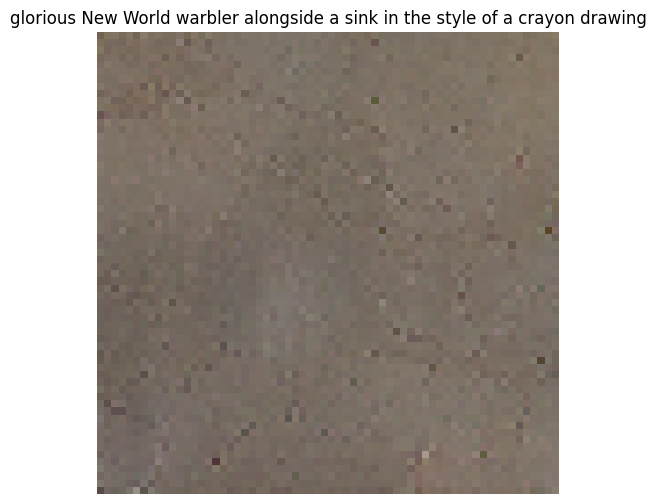

In [11]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# === Load model ===
model = PROVIS()
device = model.device

# === Load only UNet weights ===
ckpt = torch.load("Downloads/PROVIS_saved_models/best_model.pth", map_location=device)
model.unet.load_state_dict(ckpt)
model.eval()

# === Input prompt ===
prompt = ["ball"]

# === Generate image ===
with torch.no_grad():
    # Get text embeddings
    text_embeddings, attn_mask = model.get_text_embeddings(prompt)

    # Start from random latent
    latents = torch.randn((1, 4, 8, 8)).to(device)

    # DDPM sampling loop
    for t in reversed(range(model.scheduler.config.num_train_timesteps)):
        timesteps = torch.tensor([t], device=device)
        noise_pred = model.unet(
            sample=latents,
            timestep=timesteps,
            encoder_hidden_states=text_embeddings,
            encoder_attention_mask=attn_mask,
        ).sample

        latents = model.scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    decoded = model.vae.decode(latents).sample

# === Postprocess and display ===
decoded = (decoded.clamp(-1, 1) + 1) / 2  # scale to [0,1]
image = to_pil_image(decoded[0].cpu())

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(prompt[0])
plt.show()
